### **Player Re-Identification and Tracking System for Football Video**

## Objective:
 Identify players using YOLOv11 model, assign consistent IDs even if players exit and re-enter the frame.

## Methods used:
* YOLOv11 for player detection.
* DeepSORT for real-time tracking.
* ResNet50 features for appearance similarity
* LPIPS for perceptual comparison
* FID for appearance consistency across time
* IoU-based trajectory fallback matching
* Analytics: Heatmap, Trajectory, LPIPS/FID stats



Install dependencies

In [1]:
!pip install lpips
!pip install ultralytics
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Import Libraries

In [2]:
import os
import cv2
import torch
import lpips
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from torchvision.models import resnet50, inception_v3
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, deque
from math import hypot

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Configuration Setup

## Configuration
Defines global parameters and device setup.

In [4]:
class Config:
    """
    Holds all configuration parameters like file paths, model settings, and thresholds.
    """
    def __init__(self):
        self.VIDEO_PATH = '/content/15sec_input_720p.mp4'
        self.MODEL_PATH = '/content/best.pt'
        self.OUTPUT_PATH = 'output.mp4'
        self.SNAPSHOT_DIR = 'snapshots'
        self.PLAYER_CLASS = 0
        self.BALL_CLASS = 1
        self.MAX_AGE = 50
        self.N_INIT = 3
        self.IOU_THRESHOLD = 0.3
        self.SIM_THRESHOLD = 0.75
        self.BUFFER_SIZE = 10
        self.TEMP_WINDOW = 30
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Feature Extractor & Metric Modules

## Feature Extraction and Similarity Metrics
Extracts ResNet features, computes LPIPS & FID between crops.

In [9]:
class FeatureExtractor:
  """
    Extracts appearance features from cropped player images using a pre-trained ResNet50 model.
    """
  def __init__(self, device):
        self.device = device
        self.model = resnet50(pretrained=True)
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1])) # Remove the last layer
        self.model.eval().to(device)
        self.transform = T.Compose([
            T.ToPILImage(), T.Resize((224, 224)), T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  def extract(self, image):
        if image.size == 0:
            return np.zeros(2048) # Return a zero vector for empty images
        with torch.no_grad():
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            features = self.model(img_tensor).squeeze().cpu().numpy()
            return features

In [12]:
class Metrics:
    """
    Calculates LPIPS for perceptual similarity and FID for distributional feature similarity.
    """
    def __init__(self, device):
        self.device = device
        self.lpips_model = lpips.LPIPS(net='alex').to(device)
        self.inception = inception_v3(pretrained=True, transform_input=False)
        self.inception.fc = torch.nn.Identity()
        self.inception.eval().to(device)
        self.transform = T.Compose([
            T.ToPILImage(), T.Resize((224, 224)), T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def lpips(self, img1, img2):
        """
        Computes LPIPS score between two image crops.
        """
        if img1.size == 0 or img2.size == 0:
            return float('inf')
        with torch.no_grad():
            t1 = self.transform(img1).unsqueeze(0).to(self.device)
            t2 = self.transform(img2).unsqueeze(0).to(self.device)
            return self.lpips_model(t1, t2).item()

    def fid(self, crops1, crops2):
        """
        Computes Fréchet Inception Distance between two sets of crops.
        """
        f1 = self._extract_feats(crops1)
        f2 = self._extract_feats(crops2)
        if len(f1) == 0 or len(f2) == 0:
            return float('inf')
        mu1, sigma1 = np.mean(f1, axis=0), np.cov(f1, rowvar=False)
        mu2, sigma2 = np.mean(f2, axis=0), np.cov(f2, rowvar=False)
        diff = mu1 - mu2
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        covmean = covmean.real if np.iscomplexobj(covmean) else covmean
        return float(diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean))

    def _extract_feats(self, images):
        """
        Helper function to extract InceptionV3 features from a list of images.
        """
        feats = []
        for img in images:
            if img.size == 0:
                continue
            with torch.no_grad():
                t = self.transform(img).unsqueeze(0).to(self.device)
                feats.append(self.inception(t).cpu().numpy().flatten())
        return feats

### Utility: IoU Function

## IoU Function
Used to compare bounding box overlap.

In [16]:
def iou(box1, box2):
    """
    Computes Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1: [x1, y1, w1, h1] - top-left coordinates and width/height of box 1
        box2: [x2, y2, w2, h2] - top-left coordinates and width/height of box 2

    Returns:
        float: IoU score between 0 and 1
    """
    # Extract box coordinates
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Compute (x1, y1, x2, y2) format for both boxes
    x1_max, y1_max = x1 + w1, y1 + h1
    x2_max, y2_max = x2 + w2, y2 + h2

    # Compute intersection coordinates
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1_max, x2_max)
    yi2 = min(y1_max, y2_max)

    # Compute area of intersection
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    # Compute area of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Compute union area
    union_area = area1 + area2 - inter_area

    # Compute IoU
    return inter_area / union_area if union_area > 0 else 0.0


### Re-Identification Module

## Re-Identifier
Assigns consistent player IDs based on features, LPIPS, and IoU.

### Tracker with YOLO + DeepSORT

In [17]:
class ReIdentifier:
    """
    Assigns consistent player IDs based on visual similarity (ResNet + LPIPS) and location (IoU).
    """
    def __init__(self, config):
        self.cfg = config
        self.extractor = FeatureExtractor(config.DEVICE)
        self.metrics = Metrics(config.DEVICE)
        self.db_feat = defaultdict(deque)
        self.db_crop = defaultdict(deque)
        self.db_box = {}
        self.next_id = 1

    def similarity(self, f1, f2):
        """
        Computes cosine similarity between two feature vectors.
        """
        return cosine_similarity(f1.reshape(1, -1), f2.reshape(1, -1))[0][0]

    def assign_id(self, crop, bbox):
        """
        Assigns or reuses a player ID based on similarity metrics and IoU.

        Strategy:
        - Extract features from the crop.
        - Compare with stored features (last 3) for each known player ID using:
          (1) Cosine similarity
          (2) LPIPS perceptual distance
          (3) IoU of bounding boxes
        - Combine them with weighted average to get a final score.
        - If a match above similarity threshold is found, reuse the ID.
        - Otherwise, assign a new ID.
        - Maintain a fixed-size buffer of features and crops for each player.
        """
        feat = self.extractor.extract(crop)
        best_id, best_score = None, -1

        for pid, feats in self.db_feat.items():
            sim = np.mean([self.similarity(feat, f) for f in list(feats)[-3:]])
            lpips_vals = [self.metrics.lpips(crop, c) for c in list(self.db_crop[pid])[-3:]]
            lpips_sim = max(0, 1.0 - np.mean(lpips_vals)) if lpips_vals else 0
            iou_score = iou(bbox, self.db_box.get(pid, bbox))
            combined = 0.5 * sim + 0.3 * lpips_sim + 0.2 * iou_score
            if combined > best_score and sim > self.cfg.SIM_THRESHOLD:
                best_id, best_score = pid, combined

        if best_id is None:
            best_id = self.next_id
            self.next_id += 1

        if len(self.db_feat[best_id]) >= self.cfg.BUFFER_SIZE:
            self.db_feat[best_id].popleft()
        if len(self.db_crop[best_id]) >= 5:
            self.db_crop[best_id].popleft()

        self.db_feat[best_id].append(feat)
        self.db_crop[best_id].append(crop)
        self.db_box[best_id] = bbox

        return best_id


## Tracker Class
Handles player detection, tracking, heatmap, trajectory drawing and metric calculation.

### Run the Pipeline

In [18]:
class Tracker:
    """
    Combines detection, tracking, and re-identification into a pipeline.
    Generates heatmaps, trajectories, and evaluates LPIPS/FID.
    """
    def __init__(self, config):
        self.cfg = config
        self.model = YOLO(config.MODEL_PATH)
        self.tracker = DeepSort(max_age=config.MAX_AGE, n_init=config.N_INIT)
        self.reid = ReIdentifier(config)
        self.tracks = defaultdict(list)
        self.crops = defaultdict(list)
        self.heatmap = None

    def run(self):
        """
        Main loop for processing the video, detecting players, assigning IDs,
        updating heatmaps, drawing bounding boxes, and saving the output video.
        """
        cap = cv2.VideoCapture(self.cfg.VIDEO_PATH)
        w, h = int(cap.get(3)), int(cap.get(4))
        self.heatmap = np.zeros((h, w), dtype=np.float32)
        out = cv2.VideoWriter(self.cfg.OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), 30, (w, h))
        os.makedirs(self.cfg.SNAPSHOT_DIR, exist_ok=True)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # --------------------------------------------------------
            # Run YOLO detection:
            # Each frame is passed through the YOLO model to get bounding boxes.
            # Only detections with class 'player' and confidence > 0.5 are kept.
            # --------------------------------------------------------
            detections = []
            for d in self.model(frame)[0].boxes.data.tolist():
                x1, y1, x2, y2, conf, cls = d
                if int(cls) == self.cfg.PLAYER_CLASS and conf > 0.5:
                    detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'player'))

            # --------------------------------------------------------
            # DeepSORT tracking:
            # DeepSORT assigns temporary track IDs based on motion and appearance.
            # We enhance it by assigning consistent IDs using ReIdentifier.
            # Each confirmed track is re-identified and labeled with a persistent ID.
            # Also logs center points for trajectory and adds crops for analysis.
            # --------------------------------------------------------
            tracks = self.tracker.update_tracks(detections, frame=frame)

            # --------------------------------------------------------
            # Re-identification and visualization:
            # For each existing ID in the database:
            # - Compute cosine similarity between current and past features
            # - Compute LPIPS perceptual similarity between current and past crops
            # - Compute IoU between current and last known bounding boxes
            # - Combine them with weights (sim: 50%, lpips: 30%, iou: 20%)
            # - Assign to the ID with highest combined score above a similarity threshold.
            # - If no match, assign a new unique ID.
            # --------------------------------------------------------
            for tr in tracks:
                if not tr.is_confirmed():
                    continue
                l, t_, r, b = map(int, tr.to_ltrb())
                crop = frame[t_:b, l:r]
                bbox = [l, t_, r - l, b - t_]
                pid = self.reid.assign_id(crop, bbox)
                center = (int((l + r) / 2), int((t_ + b) / 2))
                self.tracks[pid].append(center)
                self.crops[pid].append(crop)
                self.heatmap[center[1], center[0]] += 1
                cv2.rectangle(frame, (l, t_), (r, b), (0, 255, 0), 2)
                cv2.putText(frame, f'P{pid}', (l, t_ - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                out.write(frame)

        cap.release()
        out.release()
        self._analytics()

    def _analytics(self):
        """
        Generates and saves:
        - Heatmap of movement
        - Trajectory map
        - LPIPS and FID score per player
        """
        plt.figure(figsize=(12, 6))
        sns.heatmap(self.heatmap, cmap='hot')
        plt.title("Player Movement Heatmap")
        plt.savefig("heatmap.png")

        traj = np.ones((*self.heatmap.shape, 3), dtype=np.uint8) * 255
        for pid, pts in self.tracks.items():
            for i in range(1, len(pts)):
                cv2.line(traj, pts[i-1], pts[i], (0, 0, 255), 2)
        cv2.imwrite("trajectories.png", traj)

        print("\n=== LPIPS and FID Stats ===")
        for pid, crops in self.crops.items():
            if len(crops) >= 4:
                mid = len(crops) // 2
                fid_val = self.reid.metrics.fid(list(crops)[:mid], list(crops)[mid:])  # Convert deque to list before slicing
                lpips_vals = [self.reid.metrics.lpips(crops[i], crops[i + 1]) for i in range(len(crops) - 1)]
                avg_lpips = np.mean(lpips_vals)
                print(f"Player {pid:2d}: Avg LPIPS = {avg_lpips:.4f}, FID = {fid_val:.2f}")


## Run the Tracker
Initializes and runs the tracking pipeline.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 177MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 174MB/s] 



0: 384x640 1 ball, 16 players, 2 referees, 71.8ms
Speed: 10.3ms preprocess, 71.8ms inference, 260.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 57.6ms
Speed: 2.5ms preprocess, 57.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 57.5ms
Speed: 2.2ms preprocess, 57.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 57.5ms
Speed: 2.1ms preprocess, 57.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 57.6ms
Speed: 2.2ms preprocess, 57.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 36.9ms
Speed: 2.2ms preprocess, 36.9ms inference, 1.4ms postprocess per image at 

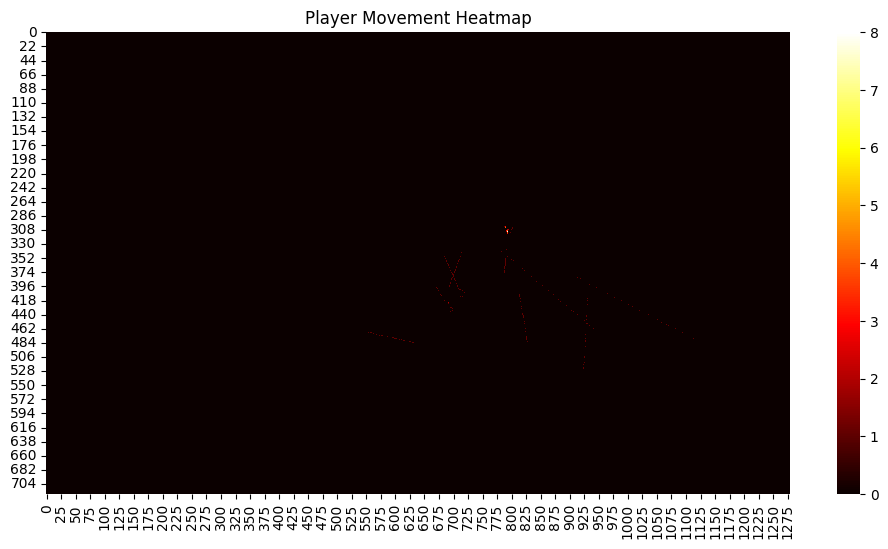

In [20]:
if __name__ == '__main__':
    """
    Entry point: initializes configuration and runs the tracker.
    """
    cfg = Config()
    trk = Tracker(cfg)
    trk.run()
    print("\nTracking complete. Outputs saved.")

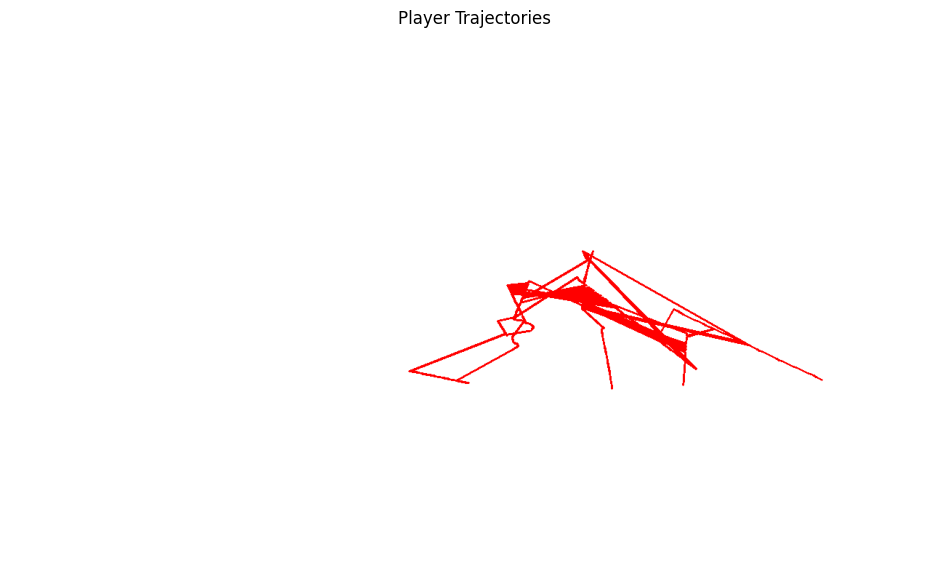

In [21]:
# Show trajectory image after processing
from PIL import Image
import matplotlib.pyplot as plt

if os.path.exists("trajectories.png"):
    img = Image.open("trajectories.png")
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Player Trajectories")
    plt.show()

###  Output Visuals

## Outputs
- `output.mp4`: Video with player IDs and bounding boxes
- `heatmap.png`: Heatmap showing player presence density
- `trajectories.png`: Trajectory paths of players
- LPIPS/FID stats printed for each player